<a href="https://colab.research.google.com/github/Darshini-A/Data-Storage-Management/blob/main/PollutionTrain%201%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [14]:
print('Imports Complete')

Imports Complete


In [15]:
train = pd.read_csv('/content/LSTM-Multivariate_AirPollution.csv')
train.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,02-01-2010 00:00,129,-16,-4.0,1020.0,SE,1.79,0,0
1,02-01-2010 01:00,148,-15,-4.0,1020.0,SE,2.68,0,0
2,02-01-2010 02:00,159,-11,-5.0,1021.0,SE,3.57,0,0
3,02-01-2010 03:00,181,-7,-5.0,1022.0,SE,5.36,1,0
4,02-01-2010 04:00,138,-7,-5.0,1022.0,SE,6.25,2,0


In [16]:
train.shape

(43800, 9)

<Axes: xlabel='date'>

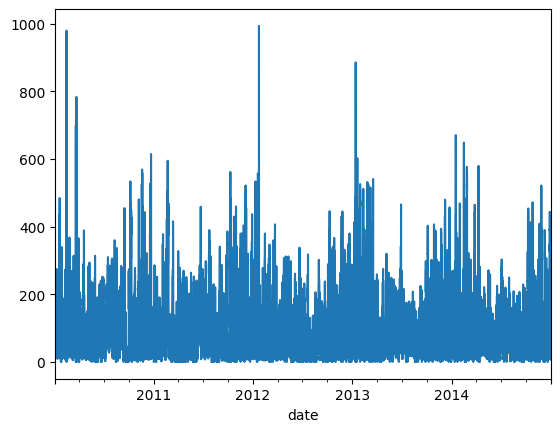

In [17]:
train.index = pd.to_datetime(train['date'], format = '%d-%m-%Y %H:%M')
poll = train['pollution']
poll.plot()

In [18]:
train.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [19]:
def wind_encode(s):
  if s == "SE":
    return 1
  elif s == "NE":
    return 2
  elif s == "NW":
    return 3
  else:
    return 4

In [20]:
train["wind_dir"] = train["wnd_dir"].apply(wind_encode)
train = train.drop(["wnd_dir", 'date'], axis=1).head()
train.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
date,,,,,,,,
2010-01-02 00:00:00,129,-16,-4.0,1020.0,1.79,0,0,1
2010-01-02 01:00:00,148,-15,-4.0,1020.0,2.68,0,0,1
2010-01-02 02:00:00,159,-11,-5.0,1021.0,3.57,0,0,1
2010-01-02 03:00:00,181,-7,-5.0,1022.0,5.36,1,0,1
2010-01-02 04:00:00,138,-7,-5.0,1022.0,6.25,2,0,1


In [21]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i : i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [22]:
WINDOW_SIZE = 5
X, y = df_to_X_y(poll, WINDOW_SIZE)
X.shape, y.shape

((43795, 5, 1), (43795,))

In [23]:
X_train, y_train = X[:35000], y[:35000]
X_val, y_val = X[35000:], y[35000 : 65000]

In [24]:
model = Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.001), metrics = [RootMeanSquaredError()])
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, verbose = 1, callbacks = [cp])

Epoch 1/10
1094/1094 [==============================] - 12s 8ms/step - loss: 5455.5688 - root_mean_squared_error: 73.8618 - val_loss: 1418.9589 - val_root_mean_squared_error: 37.6691
Epoch 2/10
1094/1094 [==============================] - 9s 8ms/step - loss: 1048.5673 - root_mean_squared_error: 32.3816 - val_loss: 781.3647 - val_root_mean_squared_error: 27.9529
Epoch 3/10
1094/1094 [==============================] - 8s 7ms/step - loss: 840.9999 - root_mean_squared_error: 29.0000 - val_loss: 625.3404 - val_root_mean_squared_error: 25.0068
Epoch 4/10
1094/1094 [==============================] - 5s 5ms/step - loss: 788.5856 - root_mean_squared_error: 28.0818 - val_loss: 639.6156 - val_root_mean_squared_error: 25.2906
Epoch 5/10
1094/1094 [==============================] - 6s 5ms/step - loss: 789.0972 - root_mean_squared_error: 28.0909 - val_loss: 822.2065 - val_root_mean_squared_error: 28.6741
Epoch 6/10
1094/1094 [==============================] - 9s 8ms/step - loss: 770.1246 - root_mean

In [26]:
model = load_model('model/')
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actual':y_train})
train_results.head()

1094/1094 [==============================] - 2s 2ms/step


,Train Predictions,Actual
0,127.305679,109
1,99.919357,105
2,107.224869,124
3,137.049377,120
4,119.613586,132


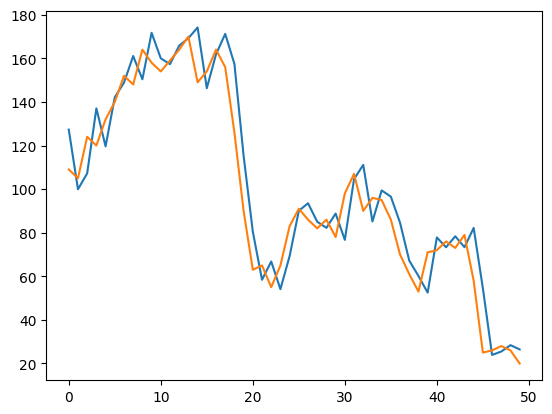

In [27]:
plt.plot(train_results['Train Predictions'][:50])
plt.plot(train_results['Actual'][:50])

In [28]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data = {'Val Predictions': val_predictions, 'Actual':y_val})
val_results.head()

275/275 [==============================] - 1s 2ms/step


,Val Predictions,Actual
0,31.446558,27
1,26.613817,25
2,24.576782,25
3,25.247944,25
4,25.288107,25


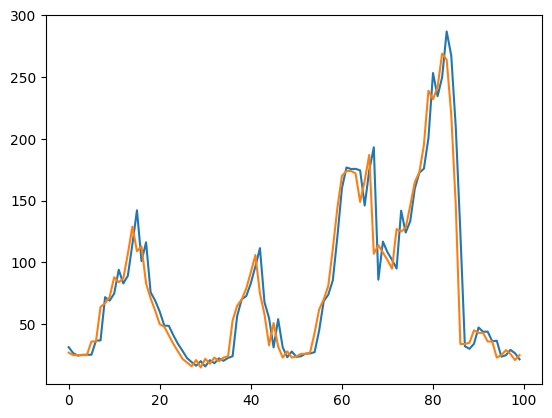

In [29]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actual'][:100])

In [31]:
rmse = np.sqrt(mse(y_val, val_predictions))
print("Validation RMSE =", rmse)

Validation RMSE = 24.364630675517336
